<h1 style="text-align: center;">Сборный проект — 2</h1>

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

**Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Описание данных

Признак                   | Значение
--------------------------|----------
id                        | уникальный идентификатор сотрудника;
dept                      | отдел, в котором работает сотрудник;
level                     | уровень занимаемой должности;
workload                  | уровень загруженности сотрудника;
employment_years          | длительность работы в компании (в годах);
last_year_promo           | показывает, было ли повышение за последний год;
last_year_violations      | показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation     | оценка качества работы сотрудника, которую дал руководитель;
salary                    | ежемесячная зарплата сотрудника;
**job_satisfaction_rate** | уровень удовлетворённости сотрудника работой в компании, целевой признак.

Тренировочная выборка: `train_job_satisfaction_rate.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

## Импорт необходимых библиотек

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import shap
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    OrdinalEncoder, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# импортируем модель
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance

## Загрузка данных

In [5]:
try:

    train_rate_df = pd.read_csv('./datasets/train_job_satisfaction_rate.csv')
    test_features_df = pd.read_csv('./datasets/test_features.csv')
    test_target_df = pd.read_csv('./datasets/test_target_job_satisfaction_rate.csv')

except:
    train_rate_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features_df = pd.read_csv('/datasets/test_features.csv')
    test_target_df = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [6]:
train_rate_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
test_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test_target_df.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Все данные успешно загружены и соответствуют описанию.

## Предобработка данных

### train_rate_df

In [9]:
train_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В таблице наблюдаются 6 пропусков по признаку департамент и 4 пропуска по признаку уровень должности. Заполним признаки позже в пайплайне. Также для экономии памяти переведём int64 в int32. В остальном все признаки имеют корректный тип данных.

In [10]:
int_columns = ['id', 'employment_years', 'supervisor_evaluation', 'salary']

for col in int_columns:
    train_rate_df[col] = train_rate_df[col].astype('int32')

Поищем дубликаты. Сначала посмотрим на явные.

In [11]:
train_rate_df.duplicated().sum()

0

Проверим наличие неявных дубликатов.

In [12]:
categorial_columns = train_rate_df.select_dtypes(exclude='number').columns.tolist()
categorial_columns

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [13]:
for col in categorial_columns:
    print(col, train_rate_df[col].unique())
    print()

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

level ['junior' 'middle' 'sinior' nan]

workload ['medium' 'high' 'low']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']



Неявных дубликатов не обнаружено.

### test_features_df

In [14]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Также наблюдаются пропуски в департаменте и уровне, заполним их в пайплайне позже. Заменим int64 на int32.

In [15]:
for col in int_columns:
    test_features_df[col] = test_features_df[col].astype('int32')

Проверим наличие явных и неявных дубликатов.

In [16]:
test_features_df.duplicated().sum()

0

In [17]:
for col in categorial_columns:
    print(col, test_features_df[col].unique())
    print()

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

level ['junior' 'middle' 'sinior' nan]

workload ['medium' 'low' 'high' ' ']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']



Дубликаты не обнаружены. Однако замечаем одно странное значение в виде пробелов в столбцах dept и workload. Посмотрим что это за строки.

In [18]:
test_features_df[(test_features_df['dept'] == ' ') | (test_features_df['workload'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Действительно по неизвестной нам причине у двух записей отсутствует либо департамент, либо уровень загруженности. Стоит проинформировать об этом разработчиков. Запомним этот факт и сделаем сответствующую обработку при подготовке данных для модели.

После окончательной проверки наблюдаем, что значений в виде пробелов не осталось.

## Исследовательский анализ данных

In [19]:
train_rate_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Изучим количественные признаки. Посмотрим на описание этих признаков.

In [20]:
numerical_columns = train_rate_df.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('id')
numerical_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [21]:
train_rate_df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


Наблюдения:
- сотрудники работают от 1 до 10 лет, в среднем около 3.5 лет
- руководители оценивают сотрудников по шкале от 1 до 5, средняя оценка около 3.5
- зарплата сотрудников колеблется от 12к до 98к, в среднем находится на уровне 34к
- сотрудники дают оценку удовлетворенности от 0.03 до 1, в среднем оценка находится на уровне 0.53

Посмотрим на графики распределения признаков.

In [22]:
def print_boxplot(df, column, title, x):
    '''
        Функция строит ящих с усами для отдельного столбца таблицы.
    '''
    fig = plt.figure(figsize=(7,2))
    plt.boxplot(df[column], vert=False)
    plt.title(title)
    plt.xlabel(x)
    plt.yticks([])
    plt.show();

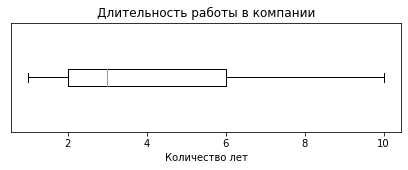

In [23]:
print_boxplot(train_rate_df, 'employment_years', 'Длительность работы в компании', 'Количество лет')

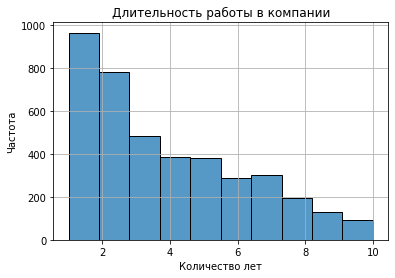

In [24]:
sns.histplot(train_rate_df['employment_years'], bins=10)

plt.title('Длительность работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.grid(True)

plt.show();

Выбросы не наблюдаются.

График имеет распределение Пуассона, то есть ассиметричен. Чаще всего сотрудники работают в компании менее 2 лет, далее чем больше количество лет, тем меньше сотрудников с таким стажем.

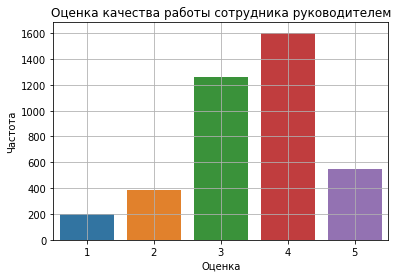

In [25]:
grades = train_rate_df['supervisor_evaluation'].value_counts() \
                .reset_index().sort_values(by='supervisor_evaluation')
grades.columns = ['supervisor_evaluation', 'count']

sns.barplot(data=grades, x='supervisor_evaluation', y='count')

plt.title('Оценка качества работы сотрудника руководителем')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.grid(True)

plt.show();

Заметим, что данный признак на самом деле относится к ранговым, так как его значения строго целые от 1 до 5. Самая часто встречаемая оценка 4, на втором месте 3. Реже всего сотрудники получают оценку 1.

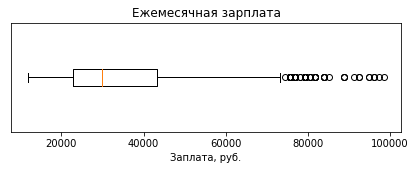

In [26]:
print_boxplot(train_rate_df, 'salary', 'Ежемесячная зарплата', 'Заплата, руб.')

Наблюдаем выбросы выше 70к. Тем не менее значения не превышают 100к руб. Такая зарплата вполне может быть реальной, хоть и является редскостью в компании, поэтому оставим выбросы без изменений.

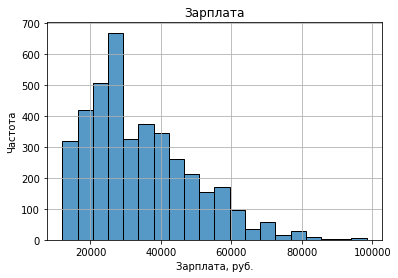

In [27]:
sns.histplot(train_rate_df['salary'], bins=20)

plt.title('Зарплата')
plt.xlabel('Зарплата, руб.')
plt.ylabel('Частота')
plt.grid(True)

plt.show();

График заплат также стремиться к распределению Пуассона. Чаще всего встречается зарплата около 30к руб.

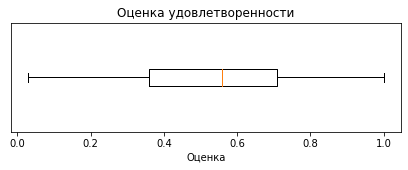

In [28]:
print_boxplot(train_rate_df, 'job_satisfaction_rate', 'Оценка удовлетворенности', 'Оценка')

В целевом признаке аномальных значений не наблюдается.

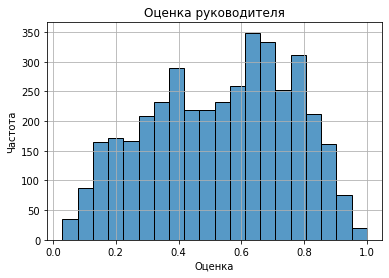

In [29]:
sns.histplot(train_rate_df['job_satisfaction_rate'], bins=20)

plt.title('Оценка руководителя')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.grid(True)

plt.show();

Рапределение целевого признака стремится к нормальному, критичного дисбаланса не наблюдается.

Посмотрим как распределены категориальные признаки.

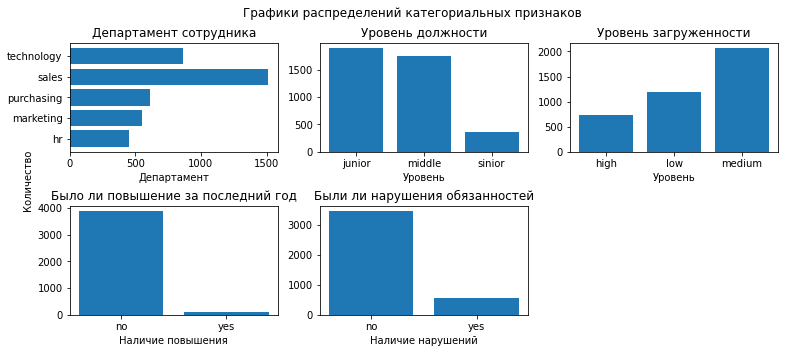

In [30]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12.7,5))
fig.suptitle("Графики распределений категориальных признаков", fontsize=12)
fig.text(0.08, 0.5, 'Количество', ha='center', va='center', rotation='vertical')

data1 = train_rate_df.groupby('dept')['id'].count().reset_index()
ax1.barh(data1['dept'], data1['id'])
ax1.set_title('Департамент сотрудника')
ax1.set_xlabel('Департамент')

data2 = train_rate_df.groupby('level')['id'].count().reset_index()
ax2.bar(data2['level'], data2['id'])
ax2.set_title('Уровень должности')
ax2.set_xlabel('Уровень')

data3 = train_rate_df.groupby('workload')['id'].count().reset_index()
ax3.bar(data3['workload'], data3['id'])
ax3.set_title('Уровень загруженности')
ax3.set_xlabel('Уровень')

data4 = train_rate_df.groupby('last_year_promo')['id'].count().reset_index()
ax4.bar(data4['last_year_promo'], data4['id'])
ax4.set_title('Было ли повышение за последний год')
ax4.set_xlabel('Наличие повышения')

data5 = train_rate_df.groupby('last_year_violations')['id'].count().reset_index()
ax5.bar(data5['last_year_violations'], data5['id'])
ax5.set_title('Были ли нарушения обязанностей')
ax5.set_xlabel('Наличие нарушений')

ax6.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show();

Наблюдения:
- больше всего сотрудников из департамента продаж sales, меньше всего из hr
- в компании работает примерно одинаковое количество junior и middle сотрудников, и очень мало sinior-ов
- у большинства сотрудников средний уровень загруженности, меньше всего сотрудников обладают высоким уровнем загруженности
- за последний код количество повышений было катострофически маленьким
- нарушения обязанностей происходят редко, примерно в 6-7 раз реже, чем работа без нарушений

К ранговым признакам относятся уровень должности, уровень загруженности.

Посмотрим поближе на долю повышений в компании.

In [31]:
train_rate_df.groupby('last_year_promo')['id'].count() / train_rate_df.shape[0]

last_year_promo
no     0.97
yes    0.03
Name: id, dtype: float64

Теперь у нас имеется точное значение, повышения добиваются всего около 3% сотрудников. Это может быть одной из веских причин на увольнение. Обратим на это внимание в дальнейшем.

### Промежуточные выводы

- сотрудники работают от 1 до 10 лет, в среднем около 3.5 лет
- руководители оценивают сотрудников по шкале от 1 до 5, средняя оценка около 3.5
- зарплата сотрудников колеблется от 12к до 98к, в среднем находится на уровне 34к
- сотрудники дают оценку удовлетворенности от 0.03 до 1, в среднем оценка находится на уровне 0.53
- больше всего сотрудников из департамента продаж sales, меньше всего из hr
- в компании работает примерно одинаковое количество junior и middle сотрудников, и очень мало sinior-ов
- у большинства сотрудников средний уровень загруженности, меньше всего сотрудников обладают высоким уровнем загруженности
- за последний код количество повышений было катострофически маленьким
- нарушения обязанностей происходят редко, примерно в 6-7 раз реже, чем работа без нарушений

Повышения добиваются всего около 3% сотрудников. Это может быть одной из веских причин на увольнение.

К ранговым признакам относятся оценка качества работы руководителем, уровень должности и уровень загруженности. Остальные признаки либо обычные категориальные, либо численные. Также необходимо не забыть заполнить пропуски.

## Корреляционный анализ

Проведем анализ того, с какими признаками целевой признак связан больше всего. Для начала превратим столбец id в индекс таблицы.

In [32]:
train_rate_df = train_rate_df.set_index('id')
train_rate_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


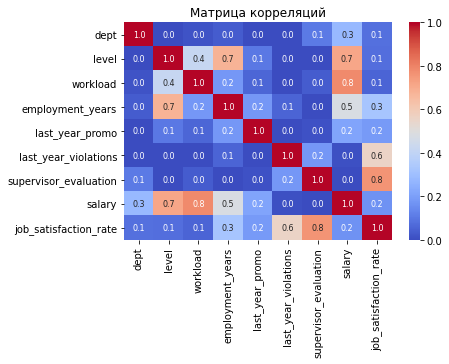

In [33]:
interv_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
phik_corr = train_rate_df.phik_matrix(interval_cols=interv_cols)
sns.heatmap(phik_corr,
            xticklabels=phik_corr.columns.values,
            yticklabels=phik_corr.columns.values,
            cmap='coolwarm',
            annot_kws={"fontsize":8},
            fmt=".1f",
            annot=True)

plt.title('Матрица корреляций')
#plt.xlabel('Названия признаков')
#plt.ylabel('Названия признаков')
plt.show();

Целевой признак `job_satisfaction_rate` больше всего зависит от `supervisor_evaluation` и `last_year_violations`, то есть от оценки руководителя и количества нарушений за последний год. Вопреки нашим ожиданиям наблюдается слабая зависимость целевого признака от наличия повышения.

Также мы наблюдаем сильную корреляцию между salary и level, salary и workload, emloyment_years и level. Все данные зависмости вполне логичны, чем выше зарплата, тем выше уровень и нагрузка. Чем больше опыт, тем выше уровень. Однако данный уровень корреляции в 0.7 и 0.8 не достаточно высокий, чтобы говорить о мультиколлинеарности, поэтому никаких действий предпренимать не будем.

Посмотрим на типы зависимостей целевого признака от количественных признаков.

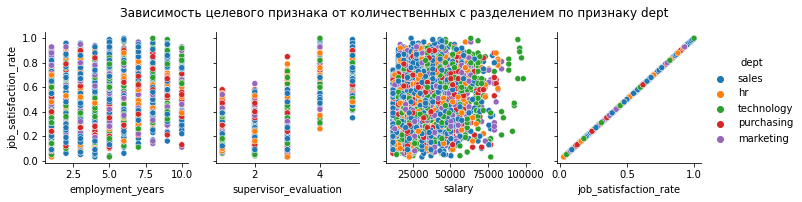

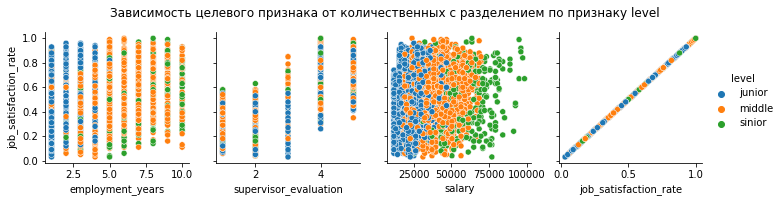

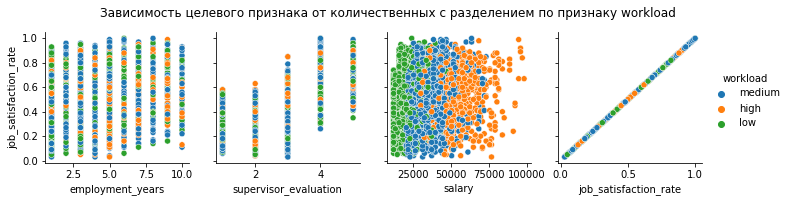

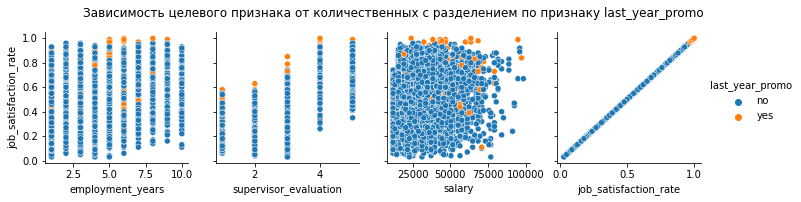

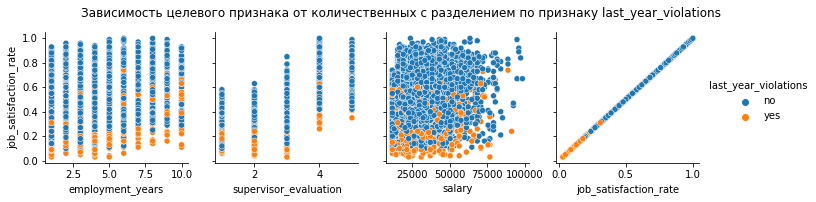

In [34]:
for category in categorial_columns:
    g = sns.PairGrid(train_rate_df, hue = category, x_vars=numerical_columns, y_vars='job_satisfaction_rate')
    g.map(sns.scatterplot)
    g.add_legend()
    g.fig.suptitle(f"Зависимость целевого признака от количественных с разделением по признаку {category}", y=1.08)

plt.show();

Ни одной линейной зависимости не наблюдается.

## Подготовка данных

Подготовим списки признаков по кодированию и масштабированию. А также отделим целевой признак.

In [35]:
test_features_df = test_features_df.sort_values(by='id')
test_target_df = test_target_df.sort_values(by='id')

In [36]:
test_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [37]:
test_target_df.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [38]:
RANDOM_STATE=42

ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']

X_train = train_rate_df.drop(columns='job_satisfaction_rate')
y_train = train_rate_df['job_satisfaction_rate']

test_features_df = test_features_df.set_index('id')
X_test = test_features_df
y_test = test_target_df['job_satisfaction_rate']

Напишем функцию, которая будет считать для нас значени новой метрики SMAPE.

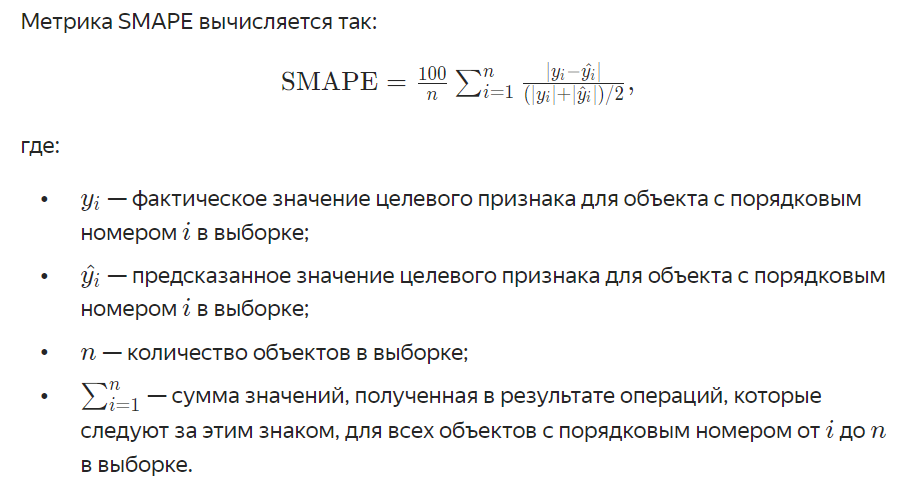

In [39]:
def smape_score(y_true, y_pred):
    '''
        Функция считает значение метрики SMAPE.
    '''
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

custom_score = make_scorer(smape_score, greater_is_better=False)

**Критерий успеха: SMAPE ≤ 15 на тестовой выборке.**

Добавляем OHE-кодирование в пайплайн. Пропуски заполняем самым часто встречающимся значением.

In [40]:
# SimpleImputer + OHE
# Added in version 1.2: sparse was renamed to sparse_output.
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Добавляем Ordinal-кодирование в пайплайн. Заполняем пропуски до кодирования (самым частым значением), кодируем и затем заполняем пропуски после кодирования. Также зададим порядок категоризации.

In [41]:
# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Объединяем шаги подготовки. Объединим кодирование и масштабирование в один пайплайн с подготовкой данных. Аргумент remainder='passthrough' позволит не применять шаги пайплайна к признакам, которые не вошли в списки, и они останутся без изменений.

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

## Обучение моделей

Создаём итоговый пайплайн для обучения модели.

In [43]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV. В словаре укажем, какие варианты масштабирования собираемся перебрать. Их три: варианты с разными методами и один вариант без масштабирования. 

В словарь гиперпараметров param_grid добавим модели, которые хотим использовать: DecisionTreeRegressor() и LinearRegression().

In [44]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2,15),
        'models__min_samples_leaf': range(1,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'models__n_jobs': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [45]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5, 
    scoring=custom_score,
    random_state=RANDOM_STATE,
    n_jobs = -1,
    error_score="raise"
)

In [46]:
randomized_search_1.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_viol...
                                         'models__min_samples_leaf': range(1, 15),
                                         'models__min_samples_split': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'models__n_jobs': range(1, 4),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [47]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Опираясь на критерий успеха "smape <= 15" можно с уверенностью сказать, что найденная лучшая модель справилась отлично.

Посмотрим на дерево лучшей модели.

In [48]:
best_model_1 = randomized_search_1.best_estimator_

preds_1 = best_model_1.predict(X_test)
smape_score(y_test, preds_1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


13.40728061685637

In [49]:
feature_names = best_model_1.named_steps['preprocessor'].get_feature_names_out()

# сформируем таблицу важности признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model_1.steps[1][1].feature_importances_
    })

# сортируем таблицу по важности — от большей к меньшей
print(feature_importances.sort_values('Importance', ascending=False))

                          Feature  Importance
9      num__supervisor_evaluation    0.683869
10                    num__salary    0.078508
8           num__employment_years    0.074470
5   ohe__last_year_violations_yes    0.051597
6                      ord__level    0.047560
7                   ord__workload    0.020362
2                 ohe__dept_sales    0.012621
4        ohe__last_year_promo_yes    0.010395
0             ohe__dept_marketing    0.009362
3            ohe__dept_technology    0.008958
1            ohe__dept_purchasing    0.002297


Самые важные признаки, которые выделила модель это `supervisor_evaluation`, `salary`, `employment_years`, то есть оценка работы сотрудника руководителем, зарплата, длительность работы в компании.

## Выводы

Лучше всего с предсказанием справилась модель **DecisionTreeRegressor** с данными параметрами: **max_depth=15, min_samples_leaf=5, min_samples_split=7**.

Метрика на тестовой выборке: smape = 13.4

Дерево решений может справляться лучше линейной регресии для задач с нелинейными зависимостями, которые мы наблюдаем в наших данных.

Самые важные признаки, которые выделила модель это `supervisor_evaluation`, `salary`, `employment_years`.

Самые **не удовлетворенные** сотрудники: получают оценку от руководителя ниже 3.5, заплату ниже 30к и работают в компании менее 2 лет.

# Задача 2: предсказание увольнения сотрудника из компании

Будем использовать те же входные признаки, что и в предыдущей задаче, с новым целевым признаком `quit` — увольнение сотрудника из компании.

Признак                   | Значение
--------------------------|----------
id                        | уникальный идентификатор сотрудника;
dept                      | отдел, в котором работает сотрудник;
level                     | уровень занимаемой должности;
workload                  | уровень загруженности сотрудника;
employment_years          | длительность работы в компании (в годах);
last_year_promo           | показывает, было ли повышение за последний год;
last_year_violations      | показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation     | оценка качества работы сотрудника, которую дал руководитель;
salary                    | ежемесячная зарплата сотрудника;
**quit**                  | увольнение сотрудника из компании

## Загрузка данных

In [50]:
try:

    train_quit_df = pd.read_csv('./datasets/train_quit.csv')
    test_features_quit_df = pd.read_csv('./datasets/test_features.csv')
    test_target_quit_df = pd.read_csv('./datasets/test_target_quit.csv')

except:
    train_quit_df = pd.read_csv('/datasets/train_quit.csv')
    test_features_quit_df = pd.read_csv('/datasets/test_features.csv')
    test_target_quit_df = pd.read_csv('/datasets/test_target_quit.csv')

In [51]:
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [52]:
test_features_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [53]:
test_target_quit_df.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Все данные успешно загружены и соответствуют описанию.

## Предобработка данных

In [54]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Пропусков не наблюдается, для экономии памяти переведём int64 в int32. Посмотрим на наличие дубликатов.

In [55]:
num_cols = train_quit_df.select_dtypes(include='number').columns.tolist()
train_quit_df[num_cols] = train_quit_df[num_cols].astype('int32')

In [56]:
train_quit_df.duplicated().sum()

0

In [57]:
cat_cols = train_quit_df.select_dtypes(exclude='number').columns.tolist()

for col in cat_cols:
    print(col, train_quit_df[col].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


Дубликаты не обнаружены.

In [58]:
test_features_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [59]:
test_features_quit_df[num_cols] = test_features_quit_df[num_cols].astype('int32')

In [60]:
test_features_quit_df.duplicated().sum()

0

In [61]:
for col in cat_cols:
    if col == 'quit':
        continue
    print(col, test_features_quit_df[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Дубликаты не обнаружены. Пропуски и пробелы заполним при подготовке данных для модели.

In [62]:
test_target_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [63]:
test_target_quit_df.duplicated().sum()

0

In [64]:
test_target_quit_df['quit'].unique()

array(['yes', 'no'], dtype=object)

В таблице с предсказаниями дубликатов и пропусков не обнаружено.

## Исследовательский анализ данных

In [65]:
train_quit_df = train_quit_df.set_index('id')
train_quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


### Портрет уволившегося сотрудника

Посмотрим на распределения непрерывных признаков в разделении по типу целевого признака.

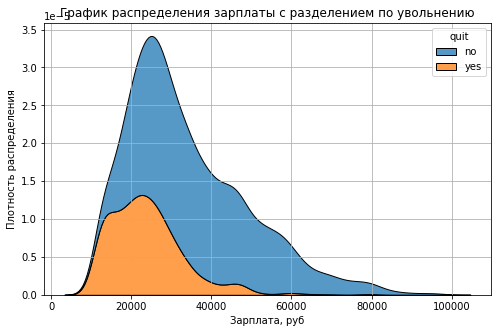

In [66]:
plt.figure(figsize=(8,5))

sns.kdeplot(data=train_quit_df, x='salary', hue='quit', multiple="stack")

plt.title('График распределения зарплаты с разделением по увольнению')
plt.xlabel('Зарплата, руб')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

У тех, кто уволился зарплата ниже 50к руб. и при в среднем ниже, чем зарплата тех, кто остаётся.

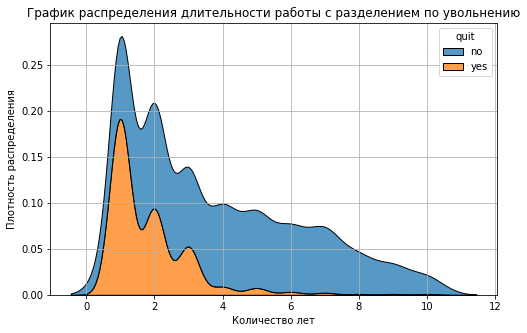

In [67]:
plt.figure(figsize=(8,5))

sns.kdeplot(data=train_quit_df, x='employment_years', hue='quit', multiple="stack")

plt.title('График распределения длительности работы с разделением по увольнению')
plt.xlabel('Количество лет')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Чаще увольняются те, кто работает в компании менее 2 лет. Все, кто вольняется, в основном работают в компании менее 4 лет.

Посмотрим на распределения дискретных признаков в разделении по типу целевого признака.

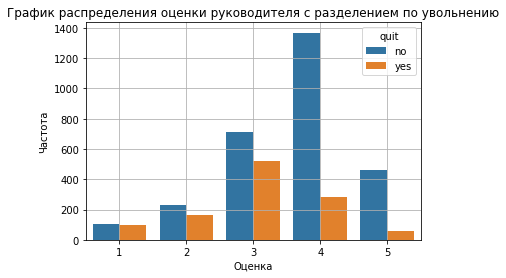

In [68]:
sns.countplot(data=train_quit_df, x='supervisor_evaluation', hue='quit')

plt.title('График распределения оценки руководителя с разделением по увольнению')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.grid(True)
plt.show();

Чаще всего увольняются с оценкой от руководителя 3.0. Самые маленькие доли увольнений у групп людей с оценками 4 и 5.

Посмотрим на распределения категориальных признаков в разделении по типу целевого признака.

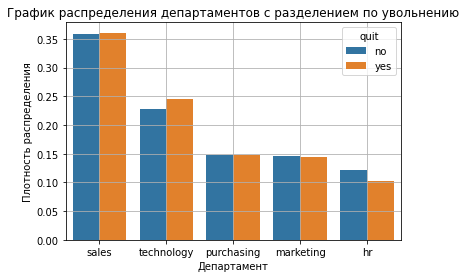

In [69]:
data = train_quit_df.groupby('quit')['dept'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='dept', y='counts', hue='quit')
  
plt.title('График распределения департаментов с разделением по увольнению')
plt.xlabel('Департамент')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

В департаментах продаж и технологий увольнения происходят чаще, чем люди остаются. Реже всего люди увольняются из департамента hr.

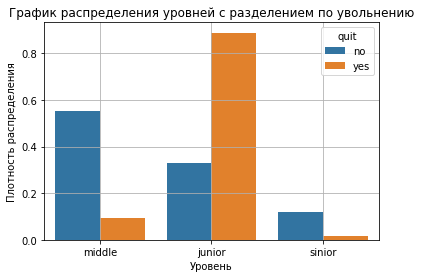

In [70]:
data = train_quit_df.groupby('quit')['level'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='level', y='counts', hue='quit')
  
plt.title('График распределения уровней с разделением по увольнению')
plt.xlabel('Уровень')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Чаще всего увольняются начинающие специалисты.

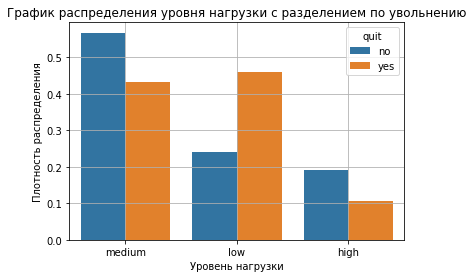

In [71]:
data = train_quit_df.groupby('quit')['workload'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='workload', y='counts', hue='quit')
  
plt.title('График распределения уровня нагрузки с разделением по увольнению')
plt.xlabel('Уровень нагрузки')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Больше всего увольнений у людей с низким увронем нагрузки.

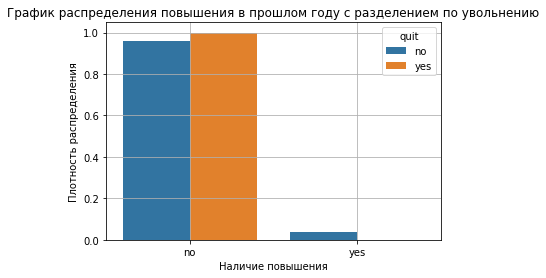

In [72]:
data = train_quit_df.groupby('quit')['last_year_promo'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='last_year_promo', y='counts', hue='quit')
  
plt.title('График распределения повышения в прошлом году с разделением по увольнению')
plt.xlabel('Наличие повышения')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Чаще увольняются те, у кого не было повышения.

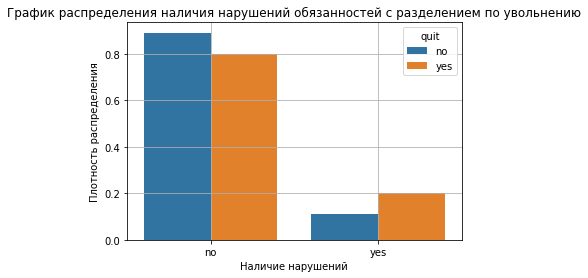

In [73]:
data = train_quit_df.groupby('quit')['last_year_violations'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='last_year_violations', y='counts', hue='quit')
  
plt.title('График распределения наличия нарушений обязанностей с разделением по увольнению')
plt.xlabel('Наличие нарушений')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Люди, нарушающие свои обязанности, чаще увольняются, чем остаются. Тем не менее доля увольнений среди не нарушающих тоже достаточно высока.

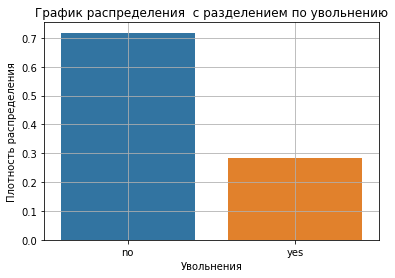

In [74]:
data = train_quit_df['quit'].value_counts(normalize=True).reset_index(name='counts')

sns.barplot(data=data, x='index', y='counts')
  
plt.title('График распределения  с разделением по увольнению')
plt.xlabel('Увольнения')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

Классы целевого признака распределены неравномерно.

Налюдения:
- в целом доля увольнений во всех департаментах примерно одинаковая
- junior сотрудники увольняются чаще, чем остаются
- чем больше длительность работы в компании, тем меньше увольнений
- сотрудники, работающие меньше 2 лет чаще увольняются, чем остаются
- среди людей, полчивших повышения, увольнения отсутствуют
- очень высокая доля увольнений среди людей, нарушающих должностные обязанности
- целевой признак распределен не равномерно

Чаще всего увольняются:
- из департамента sales, то есть продажи
- junior сотрудники
- с низким уровнем ответственности
- работающее менее 2 лет
- без повышения за последний год
- без нарушений за последний год
- с оценкой от руководителя около 3.0
- с разплатой менее 20к руб.

Самая низкое количество увольнений у сотрудников:
- middle уровня
- работающих дольше 3 лет
- с оценкой от руководителя выше 3.5
- зарплата около 30к руб

Вывод: составим **портрет уволившегося сотрудника**:
- junior уровень
- low низкий уровень ответственности
- работает меньше 2 лет
- без повышения за последний год
- с оценкой от руководителя около 3.0
- зарплата ниже 20к

Вероятнее всего это начинающие специалисты, которым не удалось добиться успеха и продвижения в компании. Трудно сказать в каком отделе больше увольняющихся сотрудников, поскольку доля увольнений приблизительно одинаковая.

### Влияние уровня удовлетворенности

Объединим две таблицы с целевыми признаками в одну по id сотрудника.

In [75]:
rate_quit_target_df = test_target_df.merge(test_target_quit_df, how='inner', on='id')
rate_quit_target_df.head()

,id,job_satisfaction_rate,quit
0,100298,0.80,no
1,100480,0.84,no
2,100503,0.79,no
3,100610,0.75,no
4,100692,0.69,no


In [76]:
rate_quit_target_df.shape

(2000, 3)

Размерность осталась той же, что означает, что для каждого сотрудника представлены оба целевых признака.

Сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.

Median no quit: 0.66
Median yes quit: 0.37


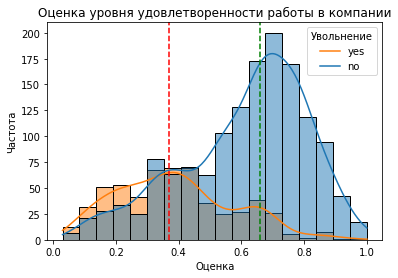

In [77]:
mean_rates = rate_quit_target_df.groupby('quit')['job_satisfaction_rate'].median()
no_mean = mean_rates['no']
yes_mean = mean_rates['yes']

print(f'Median no quit: {no_mean}')
print(f'Median yes quit: {yes_mean}')

sns.histplot(data=rate_quit_target_df, x='job_satisfaction_rate', hue='quit', kde=True)

plt.axvline(x=no_mean, color='green', linestyle='--', label='no median')
plt.axvline(x=yes_mean, color='red', linestyle='--', label='yes median')
plt.legend(['yes', 'no'], title='Увольнение')

plt.title('Оценка уровня удовлетворенности работы в компании')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show();

Среди сотрудников с оценкой удовлетворенности меньше 0.45 количество увольнений превышает количество остающихся сотрудников. Среди сотрудников с оценкой 0.5 и выше увольнения всё равно происходят, но в заметно маленьком соотношении по сравнению с остающимися сотрудниками.

Сотрудники с оценкой ниже 0.3 чаще увольняются, чем остаются.

В среднем оценка удовлетворенности среди увольняющихся равна 0.37, а среди остающихся 0.66, что подтверждает влияние оценки удовлетворенности на уход.

Можно сделать вывод, что оценка удовлетворенности действительно влияет на увольнение сотрудника.

### Промежуточный вывод

- Портрет уволившегося сотрудника: начинающие специалисты, которым не удалось добиться успеха и продвижения в компании.
- Оценка удовлетворенности действительно влияет на увольнение сотрудника.

## Добавление нового входного признака

Так как мы доказали влияение уровня удовлетворенности на увольнение, добавим признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [78]:
preds = randomized_search_1.best_estimator_.predict(train_quit_df.loc[:, train_quit_df.columns != 'quit'])

In [79]:
train_quit_df['job_satisfaction_rate'] = preds
train_quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.626667
814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.351111
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [80]:
test_features_quit_df = test_features_quit_df.merge(test_target_df, how='inner', on='id').set_index('id')
test_features_quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


Новый признак добавлен успешно.

## Подготовка данных

Подготовим списки признаков по кодированию и масштабированию. А также отделим целевой признак.

In [81]:
test_features_quit_df = test_features_quit_df.sort_index()

In [82]:
test_target_quit_df = test_target_quit_df.sort_values(by='id')

In [83]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

X_train = train_quit_df.drop(columns='quit')
y_train = train_quit_df['quit']

X_test = test_features_quit_df
y_test = test_target_quit_df['quit']

In [84]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79
100610,sales,middle,medium,5,no,no,4,43200,0.75
100692,sales,middle,high,6,no,no,4,48000,0.69


In [85]:
test_target_quit_df.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


Проверили, что id находятся в одинаковом порядке и у признаков, и у таргета.

Добавляем OHE-кодирование в пайплайн. Пропуски заполняем самым часто встречающимся значением.

In [86]:
# SimpleImputer + OHE
# Added in version 1.2: sparse was renamed to sparse_output.
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Добавляем Ordinal-кодирование в пайплайн. Заполняем пропуски до кодирования (самым частым значением), кодируем и затем заполняем пропуски после кодирования. Также зададим порядок категоризации.

In [87]:
# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Объединяем шаги подготовки. Объединим кодирование и масштабирование в один пайплайн с подготовкой данных. Аргумент remainder='passthrough' позволит не применять шаги пайплайна к признакам, которые не вошли в списки, и они останутся без изменений.

In [88]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

## Обучение модели

**Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.**

В качестве метрики выберем roc_auc, поскольку у нас наблюдается дисбаланс классов.

In [89]:
# итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV. В словаре укажем, какие варианты масштабирования собираемся перебрать. Их три: варианты с разными методами и один вариант без масштабирования. 

В словарь гиперпараметров param_grid добавим модели, которые хотим использовать: DecisionTreeClassifier(), SVС(), KNeighborsClassifier().

Перебираем гиперпараметры моделей. В каждом словаре указываем название модели, её гиперпараметры, метод масштабирования.

In [90]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 22),
        'models__min_samples_split': range(2,22),
        'models__min_samples_leaf': range(1,22),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(0,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [91]:
# задаём случайный поиск
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [92]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                         'models__max_depth': range(2, 22),
                                         'models__min_samples_leaf': range(1, 22),
                                         'models__min_samples_split': range(2, 22),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(0, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [93]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Лучшая модель показывает отличное качество на тренировочной выборке. Выполним предсказания на нашей лучшей модели.

In [94]:
best_model = randomized_search.best_estimator_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

In [95]:
preds = best_model.predict(X_test)
proba_one = best_model.predict_proba(X_test)[:,1]

acc = roc_auc_score(y_test, proba_one)
print(acc)

0.9224482160848693


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель показывает отличный результат, который удовлетворяет критерий успеха.

In [96]:
# сформируем таблицу важности признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model.steps[1][1].feature_importances_
    })

# сортируем таблицу по важности — от большей к меньшей
print(feature_importances.sort_values('Importance', ascending=False))

                          Feature  Importance
11     num__job_satisfaction_rate    0.418437
6                      ord__level    0.389755
7                   ord__workload    0.073050
10                    num__salary    0.058993
8           num__employment_years    0.056279
9      num__supervisor_evaluation    0.001589
2                 ohe__dept_sales    0.001009
1            ohe__dept_purchasing    0.000887
0             ohe__dept_marketing    0.000000
3            ohe__dept_technology    0.000000
4        ohe__last_year_promo_yes    0.000000
5   ohe__last_year_violations_yes    0.000000


Самыми важными признаками модель посчитала level, job_satisfaction_rate и salary. То есть уровень сотрудника, его оценку удовлетворенности и зарплату. В целом такая важность признаков совпадает с нашим анализом, проведенным выше.

## Выводы

- **Лучшая модель:** DecisionTreeClassifier
- **Параметры лучшей модели:** max_depth=6, min_samples_leaf=20, min_samples_split=4
- **Метрика лучшей модели на тестовой выборке:** 0.919
- **Самые важные признаки:** level, job_satisfaction_rate и salary

Дерево решений справляется лучше в задачах с нелинейными зависимостями, которые наблюдаются в задачах выше.

# Общий вывод

Целью исследования являлось выполнение двух задач:

**Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<u>Результаты первой задачи:</u>

Лучше всего с предсказанием справилась модель **DecisionTreeRegressor** с данными параметрами: **max_depth=15, min_samples_leaf=5, min_samples_split=7**.

Метрика smape лучшей модели на тестовой выборке: 13.4

Дерево решений может справляться лучше линейной регресии для задач с нелинейными зависимостями, которые мы наблюдаем в наших данных.

Самые важные признаки, которые выделила модель это `supervisor_evaluation`, `salary`, `employment_years`.

Самые **не удовлетворенные** сотрудники: получают оценку от руководителя ниже 3.5, зарплату ниже 30к руб., работают менее 2 лет

<u>Результаты второй задачи:</u>

- **Лучшая модель:** DecisionTreeClassifier
- **Параметры лучшей модели:** max_depth=6, min_samples_leaf=20, min_samples_split=4
- **Метрика лучшей модели на тестовой выборке:** 0.919
- **Самые важные признаки:** level, job_satisfaction_rate и salary

<u>Советы бизнесу:</u>

- Уровень удовлетворенности больше всего зависит от зарплаты, оценки руководителя и длительности работы в компании
- Чаще всего покидают компанию молодые специалисты, которые ещё не успели добиться успеха и продвижения в компании
- Стоит обратить внимание на взаимодействие молодых специалистов с руководителями, причины возникновения низких оценок, возможно подумать как помочь молодым специалистам двигаться вверх по карьерной лестнице